In [1]:
import redis
import hashlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ejemplo de predicción de modelo usando Redis

Este notebook muestra cómo obtener predicciones de un modelo que produce predicciones en lotes. Las predicciones se cargaron en Redis. 

En este notebook, recuperamos las predicciones del modelo almacenadas en Redis. Los datos deben ser leídos, convertidos a cadenas y luego hasheados. Con este enfoque, podemos verificar si los datos existen en Redis y recuperar la predicción correspondiente. En caso de que los datos no existan, asignamos un valor de cero. Esta estrategia simula cómo podría comportarse un servicio en producción ante casos no contemplados.

La ventaja de utilizar Redis en este contexto radica en su capacidad para almacenar datos de forma eficiente en memoria, lo que permite un acceso rápido a las predicciones previamente calculadas. Además, Redis ofrece funcionalidades de almacenamiento en caché y persistencia de datos, lo que garantiza la disponibilidad y la integridad de las predicciones incluso en entornos de producción de alta demanda.

In [2]:
# Conectamos al servidor redis (correr el docker compose previamente, sino no funcionará)
r = redis.Redis(host='localhost', port=6379, decode_responses=True)

In [6]:
# Obtención de datos para prueba

df_temp = pd.read_csv("./iris.csv", header=None)

# Sampleamos 100 valores al azar
df_temp = df_temp.sample(200)

test_values = df_temp.values.tolist()
# Conversión de valores a cadenas y hash
# Esto debería implementarse en el pipeline. Dado que los números de punto flotante pueden 
# presentar problemas debido a pequeñas variaciones, se podría considerar redondearlos.
string_values = [' '.join(map(str, sublist)) for sublist in test_values]
hashed_values = [hashlib.sha256(substring.encode()).hexdigest() for substring in string_values]  

# Obtención de las salidas del modelo desde Redis
# Estas salidas ya fueron procesadas en el pasado, por lo que consultamos Redis para obtenerlas.
model_output = [r.get(hash_key) for hash_key in hashed_values]

# Reemplazo de valores nulos con un valor predeterminado
# Esto es necesario porque, en caso de una nueva entrada que el modelo no haya visto durante 
# el procesamiento por lotes, necesitamos proporcionar una salida. Esta entrada podría ser
# encolada para su posterior procesamiento en lotes.
model_output = [value if value is not None else "setosa" for value in model_output]

Veamos la salida del modelo para diferentes entradas:

In [7]:
for index, test_value in enumerate(test_values):
    print(f"Para la entrada: {test_value}")
    
    print(f"El modelo predice que: {model_output[index]}")

Para la entrada: [5.7, 3.0, 3.8, 1.2]
El modelo predice que: versicolor
Para la entrada: [5.9, 2.2, 3.8, 1.3]
El modelo predice que: versicolor
Para la entrada: [7.2, 3.2, 5.4, 2.6]
El modelo predice que: virginica
Para la entrada: [6.5, 2.6, 4.0, 1.4]
El modelo predice que: versicolor
Para la entrada: [4.4, 3.8, 1.8, 0.2]
El modelo predice que: setosa
Para la entrada: [6.8, 2.9, 5.5, 1.9]
El modelo predice que: virginica
Para la entrada: [4.9, 3.9, 1.7, 0.2]
El modelo predice que: setosa
Para la entrada: [4.8, 3.5, 1.8, 0.1]
El modelo predice que: setosa
Para la entrada: [5.8, 3.0, 3.7, 1.3]
El modelo predice que: versicolor
Para la entrada: [6.4, 2.8, 4.6, 1.5]
El modelo predice que: versicolor
Para la entrada: [6.3, 2.7, 3.7, 1.4]
El modelo predice que: versicolor
Para la entrada: [4.6, 3.1, 1.5, 0.2]
El modelo predice que: setosa
Para la entrada: [7.0, 2.9, 5.1, 2.2]
El modelo predice que: virginica
Para la entrada: [6.7, 2.8, 5.7, 1.5]
El modelo predice que: virginica
Para la entr

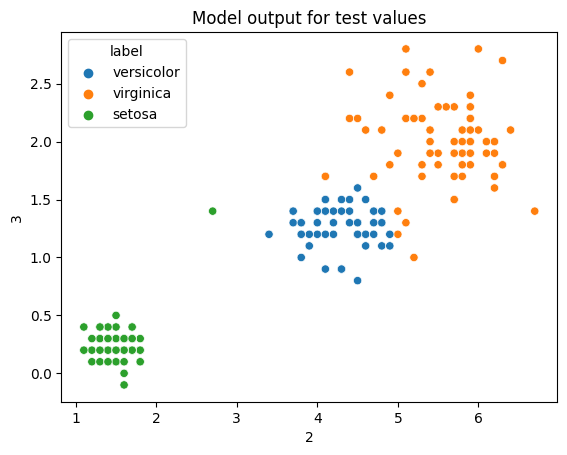

In [8]:
# Representemos graficamente a estos datos
test_values_df = pd.DataFrame(test_values)
test_values_df = pd.concat([test_values_df, pd.Series(model_output)], axis=1)
test_values_df.columns=["0", "1", "2", "3", "label"]
sns.scatterplot(x="2", y="3", hue="label", data=test_values_df)
plt.title("Model output for test values");